In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import joblib
import os
import time
import random
import seaborn as sns

# Scikit-learn
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Scikit-image
from skimage import data, transform, color, io
from skimage.feature import hog
from skimage.util import view_as_windows

# Tentativo di importare fastdup (gestione errore se non installato)
try:
    import fastdup
    FASTDUP_AVAILABLE = True
except ImportError:
    FASTDUP_AVAILABLE = False
    print("[WARNING] Libreria 'fastdup' non trovata. La pulizia degli outlier verrà saltata.")

# --- CONFIGURAZIONE GLOBALE ---
MODEL_FILENAME = "procam_face_model_v3.pkl"
PATCH_SIZE = 64
MIN_FACES_PER_PERSON = 70

[WARNING] Libreria 'fastdup' non trovata. La pulizia degli outlier verrà saltata.


In [2]:
# ==========================================
# 1. FUNZIONI DI SUPPORTO (Augmentation & Fastdup)
# ==========================================

def clean_data_with_fastdup(image_folder, work_dir="fastdup_work_dir"):
    """
    Esegue fastdup su una cartella di immagini per identificare outlier.
    Restituisce una lista di file validi (non outlier).
    """
    if not FASTDUP_AVAILABLE:
        return None

    print(f"[PRE-PROCESSING] Avvio fastdup su {image_folder}...")
    fd = fastdup.create(work_dir=work_dir)
    fd.run(input_dir=image_folder)
    
    # Otteniamo gli outlier (immagini troppo diverse dalle altre)
    outliers = fd.outliers()
    if outliers is not None and not outliers.empty:
        print(f"[PRE-PROCESSING] Trovati {len(outliers)} outliers. Verranno esclusi.")
        invalid_files = set(outliers['filename'].tolist())
    else:
        invalid_files = set()
        
    return invalid_files

def augment_image(image):
    """
    Genera varianti dell'immagine (flip, rotazione leggera).
    """
    augmented = []
    # 1. Flip Orizzontale
    augmented.append(np.fliplr(image))
    
    # 2. Rotazioni casuali (+- 10 gradi)
    angle = np.random.uniform(-10, 10)
    rotated = transform.rotate(image, angle, mode='edge')
    augmented.append(rotated)
    
    return augmented

def extract_hog(image):
    # Resize se necessario
    if image.shape != (PATCH_SIZE, PATCH_SIZE):
        image = transform.resize(image, (PATCH_SIZE, PATCH_SIZE))
        
    return hog(image, 
               orientations=9, 
               pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), 
               block_norm='L2-Hys', 
               visualize=False)

In [3]:
# ==========================================
# 2. GESTIONE DATI (Caricamento & Unbias)
# ==========================================

def load_custom_dataset(folder_path, label, limit=None):
    """
    Funzione placeholder per caricare dataset esterni (es. FairFace, UTKFace).
    """
    images = []
    if not os.path.exists(folder_path):
        print(f"[DATA] Cartella {folder_path} non trovata. Salto.")
        return np.array([])
        
    # Integrazione Fastdup (se disponibile e se cartella esiste)
    invalid_files = clean_data_with_fastdup(folder_path) or set()
    
    print(f"[DATA] Caricamento da {folder_path}...")
    count = 0
    for filename in os.listdir(folder_path):
        if filename in invalid_files: continue # Salta outlier
        
        try:
            img = io.imread(os.path.join(folder_path, filename), as_gray=True)
            img = transform.resize(img, (PATCH_SIZE, PATCH_SIZE))
            images.append(img)
            count += 1
            if limit and count >= limit: break
        except Exception as e:
            continue
            
    return np.array(images)

def get_complete_dataset():
    # 1. Caricamento LFW (Dataset Base)
    print("[DATA] Caricamento LFW (Faces)...")
    faces_lfw = fetch_lfw_people(min_faces_per_person=MIN_FACES_PER_PERSON, resize=None)
    X_faces = list(faces_lfw.images)
    
    # 2. Generazione Negativi (Non-Faces) per ridurre Falsi Positivi
    print("[DATA] Generazione Negativi (Sfondi/Oggetti)...")
    sources = [
        data.camera(), data.text(), data.coins(), data.moon(), 
        data.brick(), data.clock(), data.grass(), data.gravel(),
        data.horse(), data.coffee()
    ]
    
    X_non_faces = []
    # Rapporto aumentato a 1:5 per robustezza
    target_negatives = len(X_faces) * 5
    
    for img in sources:
        if img.ndim == 3: img = color.rgb2gray(img)
        windows = view_as_windows(img, (PATCH_SIZE, PATCH_SIZE), step=20)
        windows = windows.reshape(-1, PATCH_SIZE, PATCH_SIZE)
        
        # Prendi un sottogruppo casuale
        idx = np.random.choice(len(windows), size=min(len(windows), 600), replace=False)
        X_non_faces.extend(windows[idx])
        if len(X_non_faces) >= target_negatives: break
    
    # Resize finale dei volti LFW a 64x64
    X_faces = [transform.resize(img, (PATCH_SIZE, PATCH_SIZE)) for img in X_faces]
    
    X = np.array(X_faces + X_non_faces)
    y = np.array([1] * len(X_faces) + [0] * len(X_non_faces))
    
    print(f"[INFO] Dataset Finale -> Volti: {len(X_faces)}, Non-Volti: {len(X_non_faces)}")
    return X, y

In [4]:
# ==========================================
# 3. TRAINING & EVALUATION
# ==========================================

def train_and_evaluate():
    # A. Caricamento
    X_imgs, y = get_complete_dataset()
    
    # B. Split Train/Test (Prima dell'augmentation per evitare data leakage!)
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_imgs, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # C. Data Augmentation (Solo sul Train set)
    print("[TRAIN] Applicazione Data Augmentation (Flip, Rotate)...")
    X_train_aug = []
    y_train_aug = []
    
    for img, label in zip(X_train_raw, y_train):
        X_train_aug.append(img)
        y_train_aug.append(label)
        
        # Augmenta solo i volti (classe 1) per bilanciare meglio se necessario
        if label == 1: 
            aug_imgs = augment_image(img)
            X_train_aug.extend(aug_imgs)
            y_train_aug.extend([label] * len(aug_imgs))
            
    print(f"[INFO] Training set size dopo augmentation: {len(X_train_aug)}")
    
    # D. Feature Extraction (HOG)
    print("[TRAIN] Estrazione Features HOG...")
    X_train_hog = [extract_hog(img) for img in X_train_aug]
    X_test_hog = [extract_hog(img) for img in X_test_raw]
    
    # E. Training
    print("[TRAIN] Addestramento SVM...")
    model = LinearSVC(C=0.01, random_state=42, class_weight='balanced', dual='auto')
    model.fit(X_train_hog, y_train_aug)
    
    # F. Valutazione
    print("\n[RESULT] Valutazione sul Test Set:")
    y_pred = model.predict(X_test_hog)
    
    # Metriche
    print(classification_report(y_test, y_pred, target_names=["Non-Face", "Face"]))
    
    # Matrice di Confusione
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Face", "Face"], yticklabels=["Non-Face", "Face"])
    plt.title("Matrice di Confusione")
    plt.ylabel("Reale")
    plt.xlabel("Predetto")
    plt.show()
    
    # G. Visualizzazione Random Samples
    print("\n[RESULT] Visualizzazione Random Samples dal Test Set...")
    indices = np.random.choice(len(X_test_raw), 5, replace=False)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.imshow(X_test_raw[idx], cmap='gray')
        pred_label = "Face" if y_pred[idx] == 1 else "Non-Face"
        true_label = "Face" if y_test[idx] == 1 else "Non-Face"
        color_title = 'green' if pred_label == true_label else 'red'
        ax.set_title(f"P: {pred_label}\nT: {true_label}", color=color_title)
        ax.axis('off')
    plt.show()
    
    return model

In [5]:
# ==========================================
# 4. FACE DETECTION LOGIC (Sliding Window)
# ==========================================

def sliding_window(image, step_size, window_size):
    """
    Scorre una finestra sull'immagine e restituisce le coordinate e il ritaglio (patch).
    """
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def procam_face_detector(image, model, min_confidence=0.5):
    """
    Rileva volti in un'immagine usando Sliding Window + HOG + SVM.
    """
    detected_faces = []
    
    # 1. Pre-processing: Converti in scala di grigi se necessario
    if image.ndim == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image

    # 2. Sliding Window
    # Usa un passo (step_size) di 10-20 px. Più piccolo = più preciso ma più lento.
    step_size = 20 
    window_dims = (PATCH_SIZE, PATCH_SIZE) # (64, 64) definito globalmente

    print("[DETECTION] Avvio scansione sliding window...")
    
    # Raccogli tutte le patch per processarle (opzionale: batch processing per velocità)
    patches_coords = []
    hog_feats = []
    
    for (x, y, window) in sliding_window(gray_image, step_size, window_dims):
        # Se la finestra non è della dimensione giusta (bordi), salta
        if window.shape != window_dims:
            continue
            
        # Estrai HOG per la finestra corrente
        # Nota: usiamo la tua funzione extract_hog definita prima
        feats = extract_hog(window)
        hog_feats.append(feats)
        patches_coords.append((x, y))

    if not hog_feats:
        return []

    # 3. Classificazione (Vettorizzata per velocità)
    hog_feats = np.array(hog_feats)
    
    # Usiamo decision_function per avere lo "score" (distanza dall'iperpiano)
    # Più alto è lo score, più è probabile che sia un volto.
    scores = model.decision_function(hog_feats)
    
    # 4. Filtraggio (Confidence Threshold)
    for i, score in enumerate(scores):
        if score > min_confidence:
            x, y = patches_coords[i]
            # Formato: (x, y, w, h, score)
            detected_faces.append((x, y, window_dims[0], window_dims[1], score))

    # (Opzionale) Qui si dovrebbe applicare Non-Maximum Suppression (NMS) 
    # per eliminare box sovrapposti, ma per ora restituiamo tutto.
    
    return detected_faces

=== ProCam S.p.A. Face Detection System ===
[INIT] Trovato modello salvato. Caricamento...

[TEST] Analisi immagine 'Astronauta'...
[DETECTION] Avvio scansione sliding window...
[RESULT] Rilevati 1 volti in 0.202s.
[RESULT] Coordinate: [(180, 120, 64, 64, 0.5917151865738453)]


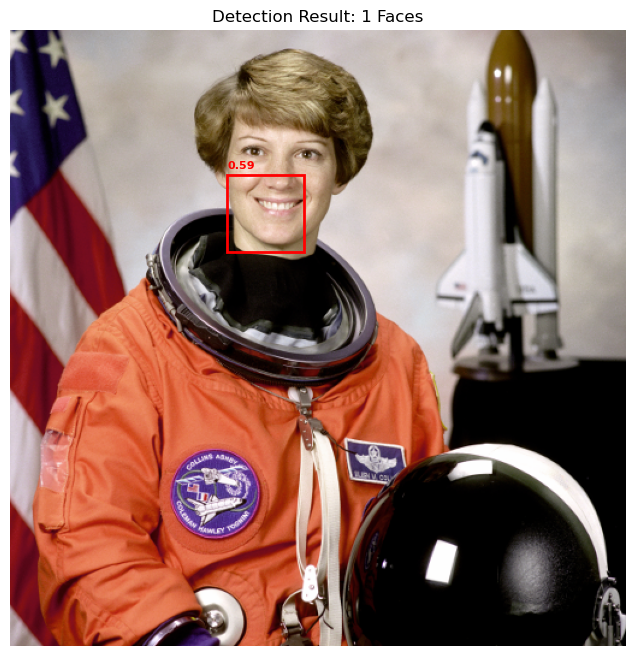

In [6]:
# ==========================================
# 5. MAIN PROGRAM
# ==========================================

if __name__ == "__main__":
    print("=== ProCam S.p.A. Face Detection System ===")
    
    # 1. Caricamento o Training
    if os.path.exists(MODEL_FILENAME):
        print(f"[INIT] Trovato modello salvato. Caricamento...")
        model = joblib.load(MODEL_FILENAME)
    else:
        print("[INIT] Nessun modello trovato. Avvio Training...")
        start_t = time.time()
        
        # CORREZIONE 1: Usa il nome corretto della funzione definita nella Cella 4
        model = train_and_evaluate() 
        
        # Salvataggio modello
        joblib.dump(model, MODEL_FILENAME)
        print(f"[INIT] Training completato in {time.time()-start_t:.1f}s.")

    # 2. Test
    print("\n[TEST] Analisi immagine 'Astronauta'...")
    test_image = data.astronaut()
    
    start_t = time.time()
    
    # Nota: min_confidence dipende da come hai addestrato. Se trovi 0 volti, abbassa a 0.5 o 0.0
    faces = procam_face_detector(test_image, model, min_confidence=0.5)
    end_t = time.time()
    
    print(f"[RESULT] Rilevati {len(faces)} volti in {end_t-start_t:.3f}s.")
    print(f"[RESULT] Coordinate: {faces}")
    
    # 3. Visualizzazione
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(test_image)
    ax.axis('off')
    
    # Disegna i rettangoli
    for (x, y, w, h, score) in faces:
        # Colore rosso, spessore 2
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Aggiungi score come testo (opzionale)
        ax.text(x, y - 5, f"{score:.2f}", color='red', fontsize=8, weight='bold')

    plt.title(f"Detection Result: {len(faces)} Faces")
    plt.show()